In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import gymnasium as gym
import numpy as np
from abc import ABC, abstractmethod
import gymnasium
import pandas as pd
import cookiedisaster
import imageio

In [2]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, state):
        return self.network(state)

In [3]:
class DQNAgent:
    def __init__(self, input_dim, action_space):
        self.model = DQN(input_dim, action_space.n)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995

        # normalization parameters
        self.max_obs = np.array([-np.inf] * input_dim)
        self.min_obs = np.array([np.inf] * input_dim)

    def normalize_observation(self, obs):
        self.max_obs = np.maximum(self.max_obs, obs)
        self.min_obs = np.minimum(self.min_obs, obs)
        n_range = np.where(self.max_obs > self.min_obs, self.max_obs - self.min_obs, 1)  # avoid division by zero
        return (obs - self.min_obs) / n_range

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, self.model.network[-1].out_features)
        else:
            state = torch.FloatTensor([state])
            q_values = self.model(state)
            return torch.argmax(q_values).item()

    def train(self, state, action, reward, next_state):
        state = torch.FloatTensor([state])
        next_state = torch.FloatTensor([next_state])
        action = torch.LongTensor([action])
        reward = torch.FloatTensor([reward])

        current_q = self.model(state).gather(1, action.unsqueeze(1))
        next_q = self.model(next_state).max(1)[0].detach()
        expected_q = reward + self.gamma * next_q

        loss = nn.MSELoss()(current_q.squeeze(0), expected_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def save(self, filename):
        torch.save(self.model.state_dict(), filename)

    def load(self, filename):
        self.model.load_state_dict(torch.load(filename))

In [4]:
envs = [gymnasium.make("cookiedisaster-v1", render_mode="rgb_array"),
        gymnasium.make("cookiedisaster-v2", render_mode="rgb_array"),
        gymnasium.make("cookiedisaster-v3", render_mode="rgb_array")]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/envs/registration.py:518: DeprecationWarning: WARN: The environment cookiedisaster-v1 is out of date. You should consider upgrading to version `v3`.
  logger.deprecation(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/envs/registration.py:518: DeprecationWarning: WARN: The environment cookiedisaster-v2 is out of date. You should consider upgrading to version `v3`.
  logger.deprecation(


In [5]:
envs[0].reset()
envs[1].reset()
envs[2].reset()
envs[0].step(0)
envs[1].step(0)
envs[2].step(0)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:133: UserWarning: WARN: The obs returned by the `reset()` method was expecting a numpy array, actual type: <class 'dict'>
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/spaces/box.py:240: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:161: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:133: UserWarning: WARN: The obs returned by the `step()` method was expecting a numpy array, actual type: <class 'dict'>
  logger.

({'agent': {'pos': 5.8, 'vel': -1.0},
  'cookie': {'pos': 7.607972372935929, 'time': 7}},
 0,
 False,
 False,
 {'distance': 1.8079723729359296, 'steps': 1})

In [6]:
def get_features(obs, info):
    agent_pos = obs["agent"]["pos"]
    agent_vel = obs["agent"]["vel"]
    cookie_pos = obs["cookie"]["pos"]
    cookie_time = obs["cookie"]["time"]
    dist = info["distance"]

    return [agent_pos, agent_vel, cookie_pos, cookie_time, dist]

In [7]:
input_dim = 5
action_space = envs[0].action_space

agent = DQNAgent(input_dim, action_space)
num_episodes = 200
max_steps_per_episode = 1000
rewards = []

for episode in range(num_episodes):
    env = envs[episode % 3]
    obs, info = env.reset()
    state = get_features(obs, info)
    state = agent.normalize_observation(np.array(state))
    total_reward = 0

    for step in range(max_steps_per_episode):
        action = agent.select_action(state)
        next_obs, reward, _, _, next_info = env.step(action)
        total_reward += reward
        next_state = get_features(next_obs, next_info)
        next_state = agent.normalize_observation(np.array(next_state))
        agent.train(state, action, reward, next_state)
        state = next_state
        total_reward += reward

    rewards.append(total_reward)
    print(f"\rEpisode: {episode + 1}   Reward: {total_reward:.3f}   Env: {episode % 3 + 1}", end="")

/var/folders/jw/pgkdvp6n17gcz8m_r8dtjdv40000gn/T/ipykernel_17597/1968536794.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  state = torch.FloatTensor([state])


Episode: 200   Reward: 179.515   Env: 2

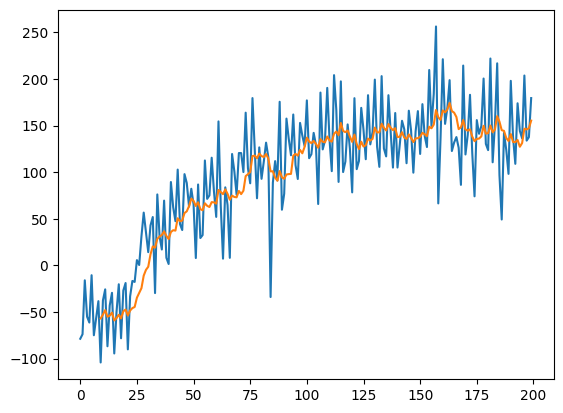

In [8]:
plt.plot(rewards)
plt.plot(pd.Series(rewards).rolling(10).mean(), label="10-Episode Rolling Mean")
plt.show()

In [9]:
agent.save("dqn_agent.pth")

In [10]:
new_agent = DQNAgent(input_dim, action_space)
new_agent.load("dqn_agent.pth")

In [11]:
total_rewards = []
num_eval_episodes = 1000
max_eval_steps_per_episode = 1000

for episode in range(num_eval_episodes):
    obs, info = envs[2].reset()
    state = get_features(obs, info)
    state = new_agent.normalize_observation(np.array(state))
    total_reward = 0

    for step in range(max_eval_steps_per_episode):
        action = new_agent.select_action(state)
        next_obs, reward, _, _, next_info = envs[2].step(action)
        total_reward += reward
        next_state = get_features(next_obs, next_info)
        next_state = new_agent.normalize_observation(np.array(next_state))
        state = next_state

    total_rewards.append(total_reward)
    print(f"\rEval Episode: {episode + 1}   Reward: {total_reward:.3f}", end="")

Eval Episode: 1000   Reward: -22.479

In [12]:
average_reward = np.mean(total_rewards)
print(f"Average Reward: {average_reward:.3f}")

Average Reward: -20.445


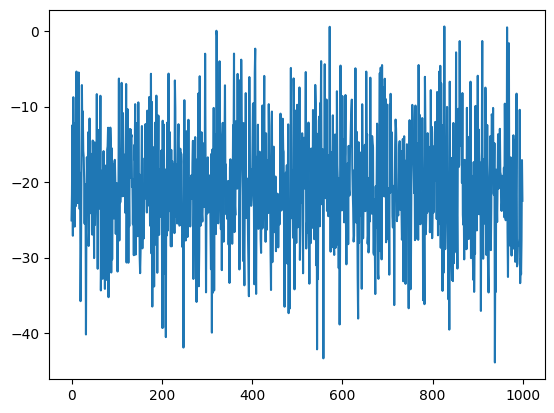

In [14]:
plt.plot(total_rewards)
plt.show()